
# 🧠 Medulloblastoma Classification
This notebook guides you through analyzing pathomic, radiomic, and clinical features for medulloblastoma subjects. See documentation on this approach:

- General classification: https://scikit-learn.org/stable/auto_examples/classification/index.html

First let's load the requisite Python packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif


Load the cleaned features, if not already in your workspace environment

In [2]:
radiomic_feats = pd.read_csv('radiomic_feats.csv')
pathomic_feats = pd.read_csv('pathomic_feats.csv')
subtypes_radiomics = pd.read_csv('molec_subtypes_2025_07_30_radiomics.csv')
subtypes_pathomics = pd.read_csv('molec_subtypes_2025_07_30_pathomics.csv')

Add the column `Age at Diagnosis` from the clinical data table to the imaging feature tables

In [3]:
#Build dataframes (no age)
df_radiomics = pd.merge(radiomic_feats, subtypes_radiomics[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']],
                        on='CBTN Subject ID', how='inner')
df_pathomics = pd.merge(pathomic_feats, subtypes_pathomics[['CBTN Subject ID', 'OpenPedCan Molecular Subtype']],
                        on='CBTN Subject ID', how='inner')
df_radiomics = df_radiomics.rename(columns={'OpenPedCan Molecular Subtype': 'Subtype'})
df_pathomics = df_pathomics.rename(columns={'OpenPedCan Molecular Subtype': 'Subtype'})

## Classification of Subtype - Radiomic Data

Initialize an SVM classifier.

In [4]:
clf = LinearSVC(max_iter=5000)

For each unique subject ID, split the subject's data as a separate test set from the rest of the training data. Fit the model to the training data, and use the fitted model to predict the class of the held-out sample. Construct an array/list of the results, including the `true-class-label` and `predicted-class-label` for each sample.

As input to `model.fit`/`model.predict`, `X` and `y` will need to be numpy array format (e.g., `X.values`).

For the radiomic features, on each loop iteration select the top 5% of features (`selector = SelectPercentile(f_classif, percentile=5)`) using only the training data, before running the classification training/testing

In [5]:
#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_radiomics['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_radiomics['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_radiomics[df_radiomics['CBTN Subject ID'] == sub_id]
    train_df = df_radiomics[df_radiomics['CBTN Subject ID'] != sub_id]

    X_train = train_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_train = train_df['Subtype']

    X_test = test_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)

    decision_scores.extend(clf.decision_function(X_test_sel))

Calculate the average testing accuracy and F1 scores across all subjects. One-hot encode the labels (`LabelBinarizer()`) and calculate the AUC score

In [6]:
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores), average='weighted', multi_class='ovr')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

Accuracy: 0.5729
F1 Score: 0.5667
AUC Score: 0.7274


Plot the confusion matrix of the true vs. predicted labels with `confusion_matrix()` and `ConfusionMatrixDisplay`

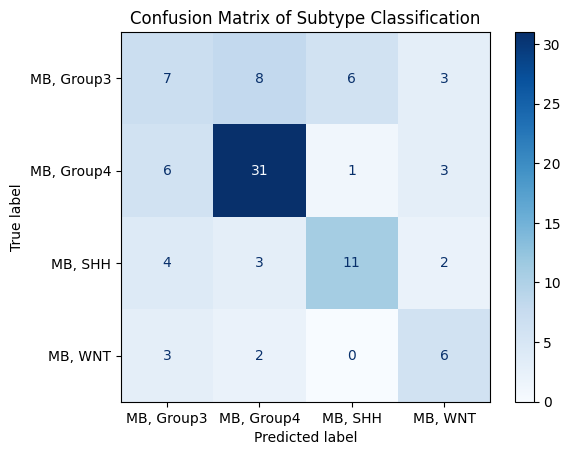

In [7]:
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
cm_disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Subtype Classification")
plt.show()

#### 2 Way/3 Way Classification

2-Way Classification (SHH/WNT vs Group3/4)
Accuracy: 0.7083
F1 Score: 0.7026
AUC Score: 0.7973


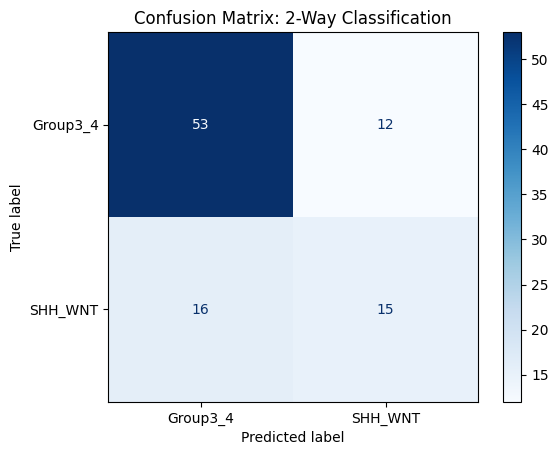

In [8]:
#Map subtypes into 2 groups
df_2way = df_radiomics.copy()
df_2way['Subtype'] = df_2way['Subtype'].replace({
    'MB, SHH': 'SHH_WNT',
    'MB, WNT': 'SHH_WNT',
    'MB, Group3': 'Group3_4',
    'MB, Group4': 'Group3_4'})

#Intialize an SVM classifier
clf = LinearSVC(max_iter=5000)

#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_2way['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_2way['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_2way[df_2way['CBTN Subject ID'] == sub_id]
    train_df = df_2way[df_2way['CBTN Subject ID'] != sub_id]

    X_train = train_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_train = train_df['Subtype']
    X_test = test_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)
    decision_scores.extend(clf.decision_function(X_test_sel))

#Compute metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores), average='weighted')

print("2-Way Classification (SHH/WNT vs Group3/4)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

#Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 2-Way Classification")
plt.show()


3-Way Classification (SHH vs WNT vs Group3/4)
Accuracy: 0.7292
F1 Score: 0.7268
AUC Score: 0.8139


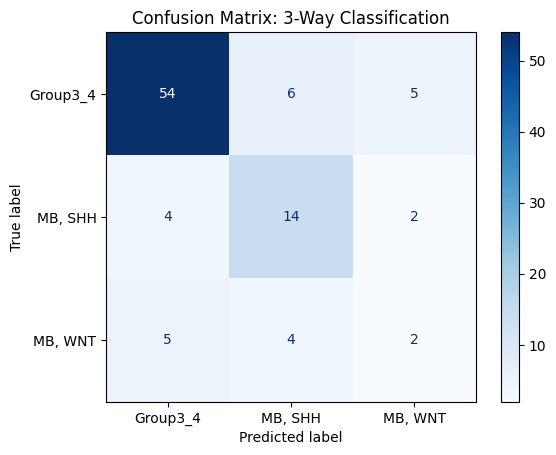

In [39]:
#Map Group3/4 together
df_3way = df_radiomics.copy()
df_3way['Subtype'] = df_3way['Subtype'].replace({
    'MB, Group3': 'Group3_4',
    'MB, Group4': 'Group3_4'
})

#Intialize an SVM classifier
clf = LinearSVC(max_iter=5000)

#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_3way['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_3way['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_3way[df_3way['CBTN Subject ID'] == sub_id]
    train_df = df_3way[df_3way['CBTN Subject ID'] != sub_id]

    X_train = train_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_train = train_df['Subtype']
    X_test = test_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)
    decision_scores.extend(clf.decision_function(X_test_sel))

#Compute metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores), average='weighted', multi_class='ovr')

print("3-Way Classification (SHH vs WNT vs Group3/4)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

#Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 3-Way Classification")
plt.show()


## Classification of Subtype - Pathomic Data

In [14]:
#Intialize an SVM classifier
clf = LinearSVC(max_iter=5000)

In [19]:
# Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

# Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_pathomics['Subtype'])

# Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_pathomics['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_pathomics[df_pathomics['CBTN Subject ID'] == sub_id]
    train_df = df_pathomics[df_pathomics['CBTN Subject ID'] != sub_id]

    #Drop non numeric columns
    X_train = train_df.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'Subtype'])
    y_train = train_df['Subtype']

    X_test = test_df.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)

    decision_scores.extend(clf.decision_function(X_test_sel))


In [20]:
#Compute Metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores), average='weighted', multi_class='ovr')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

Accuracy: 0.4451
F1 Score: 0.4079
AUC Score: 0.6395


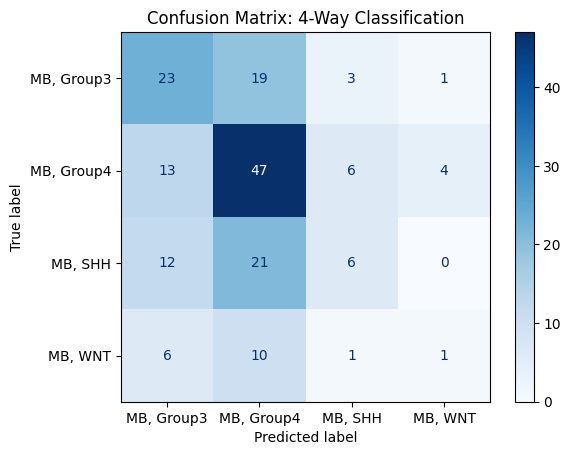

In [22]:
#Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 4-Way Classification")
plt.show()

2-Way Pathomics Classification (SHH/WNT vs Group3/4)
Accuracy: 0.6532
F1 Score: 0.5964
AUC Score: 0.5346


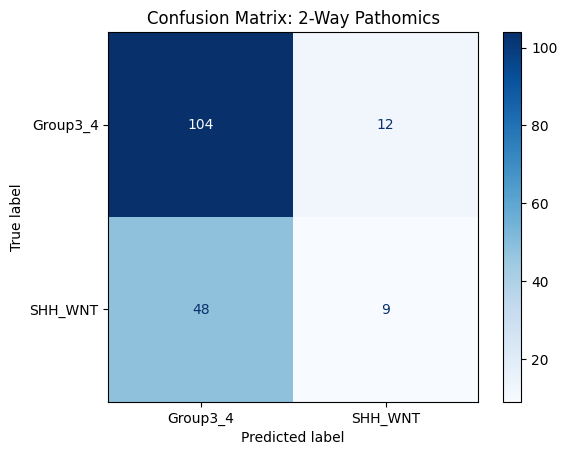

In [23]:
#Map subtypes into 2 groups
df_2way = df_pathomics.copy()
df_2way['Subtype'] = df_2way['Subtype'].replace({
    'MB, SHH': 'SHH_WNT',
    'MB, WNT': 'SHH_WNT',
    'MB, Group3': 'Group3_4',
    'MB, Group4': 'Group3_4'
})

#Initialize classifier
clf = LinearSVC(max_iter=5000)

#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_2way['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_2way['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_2way[df_2way['CBTN Subject ID'] == sub_id]
    train_df = df_2way[df_2way['CBTN Subject ID'] != sub_id]

    #Drop non-numeric columns
    X_train = train_df.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'Subtype'])
    y_train = train_df['Subtype']
    X_test = test_df.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)
    decision_scores.extend(clf.decision_function(X_test_sel))

#Compute metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores))

print("2-Way Pathomics Classification (SHH/WNT vs Group3/4)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

#Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 2-Way Pathomics")
plt.show()


3-Way Pathomics Classification (SHH vs WNT vs Group3/4)
Accuracy: 0.6358
F1 Score: 0.5481
AUC Score: 0.5896


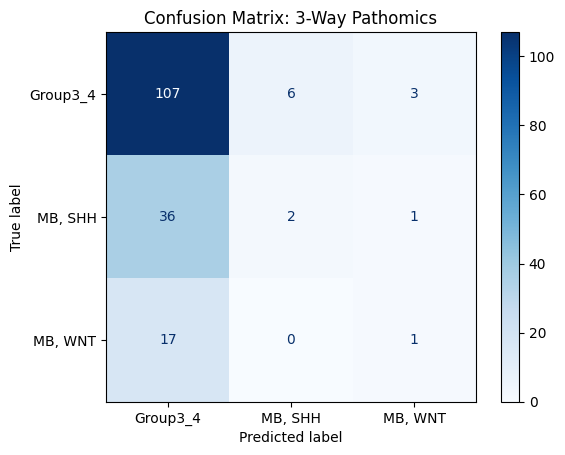

In [24]:
#Map Group3 and Group4 together
df_3way = df_pathomics.copy()
df_3way['Subtype'] = df_3way['Subtype'].replace({
    'MB, Group3': 'Group3_4',
    'MB, Group4': 'Group3_4'
})

#Initialize classifier
clf = LinearSVC(max_iter=5000)

#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_3way['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_3way['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_3way[df_3way['CBTN Subject ID'] == sub_id]
    train_df = df_3way[df_3way['CBTN Subject ID'] != sub_id]

    #Drop non-numeric columns
    X_train = train_df.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'Subtype'])
    y_train = train_df['Subtype']
    X_test = test_df.drop(columns=['CBTN Subject ID', 'CBTN Specimen Group ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)
    decision_scores.extend(clf.decision_function(X_test_sel))

#Compute metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores), average='weighted', multi_class='ovr')

print("3-Way Pathomics Classification (SHH vs WNT vs Group3/4)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

#Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 3-Way Pathomics")
plt.show()


##Classification of Subtype - Radiomic + Pathomic Data

In [40]:
#Average all numeric features per subject
df_radiomics_avg = df_radiomics.groupby('CBTN Subject ID').mean(numeric_only=True).reset_index()
df_pathomics_avg = df_pathomics.groupby('CBTN Subject ID').mean(numeric_only=True).reset_index()

In [41]:
#Reattach unique subtype labels
subtypes_r = df_radiomics[['CBTN Subject ID', 'Subtype']].drop_duplicates()
subtypes_p = df_pathomics[['CBTN Subject ID', 'Subtype']].drop_duplicates()

# Use radiomic subtype labels and merge by subject ID
df_radiomics_avg = pd.merge(df_radiomics_avg, subtypes_r, on='CBTN Subject ID', how='inner')
df_pathomics_avg = pd.merge(df_pathomics_avg, subtypes_p, on='CBTN Subject ID', how='inner')
df_pathomics_avg = df_pathomics_avg.drop(columns=['Subtype'])
df_combined = pd.merge(df_radiomics_avg, df_pathomics_avg, on='CBTN Subject ID', how='inner')

4-Way Classification (Radiomic + Pathomic)
Accuracy: 0.5333
F1 Score: 0.5278
AUC Score: 0.7711


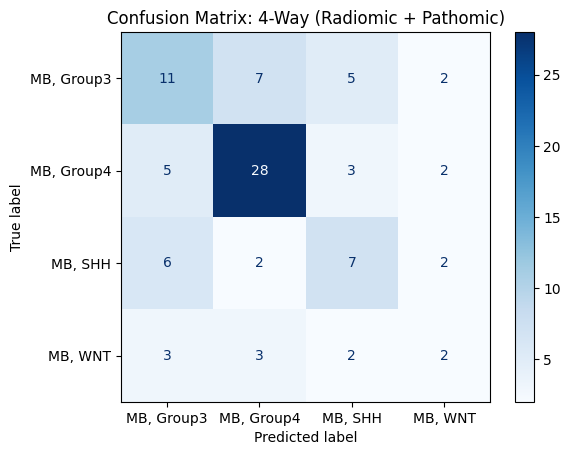

In [36]:
#Initialize classifier
clf = LinearSVC(max_iter=5000)

#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_combined['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_combined['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_combined[df_combined['CBTN Subject ID'] == sub_id]
    train_df = df_combined[df_combined['CBTN Subject ID'] != sub_id]

    X_train = train_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_train = train_df['Subtype']

    X_test = test_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)
    decision_scores.extend(clf.decision_function(X_test_sel))

#Compute metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores), average='weighted', multi_class='ovr')

print("4-Way Classification (Radiomic + Pathomic)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

#Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 4-Way (Radiomic + Pathomic)")
plt.show()

2-Way Classification (SHH/WNT vs Group3/4, Combined Features)
Accuracy: 0.7222
F1 Score: 0.7173
AUC Score: 0.7278


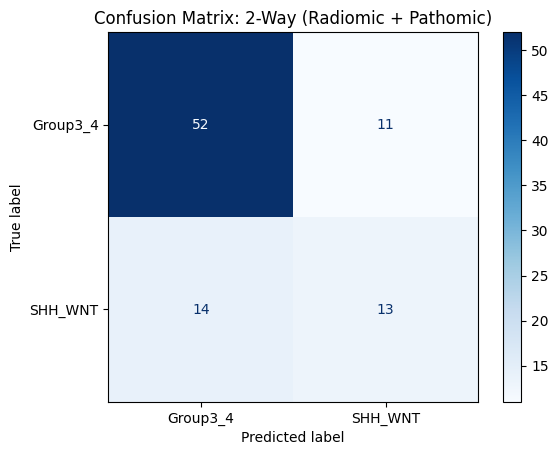

In [37]:
#Map subtypes into 2 groups
df_2way = df_combined.copy()
df_2way['Subtype'] = df_2way['Subtype'].replace({
    'MB, SHH': 'SHH_WNT',
    'MB, WNT': 'SHH_WNT',
    'MB, Group3': 'Group3_4',
    'MB, Group4': 'Group3_4'
})

#Initialize classifier
clf = LinearSVC(max_iter=5000)

#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_2way['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_2way['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_2way[df_2way['CBTN Subject ID'] == sub_id]
    train_df = df_2way[df_2way['CBTN Subject ID'] != sub_id]

    X_train = train_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_train = train_df['Subtype']

    X_test = test_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)
    decision_scores.extend(clf.decision_function(X_test_sel))

#Compute metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores))

print("2-Way Classification (SHH/WNT vs Group3/4, Combined Features)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

#Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 2-Way (Radiomic + Pathomic)")
plt.show()

3-Way Classification (SHH vs WNT vs Group3/4, Combined Features)
Accuracy: 0.7000
F1 Score: 0.7130
AUC Score: 0.7630


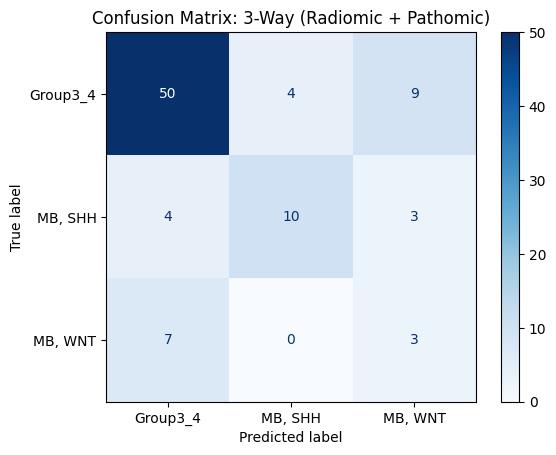

In [38]:
#Map Group3 and Group4 together
df_3way = df_combined.copy()
df_3way['Subtype'] = df_3way['Subtype'].replace({
    'MB, Group3': 'Group3_4',
    'MB, Group4': 'Group3_4'
})

#Initialize classifier
clf = LinearSVC(max_iter=5000)

#Store labels/outputs
true_labels = []
pred_labels = []
decision_scores = []

#Convert categorical vars
lb = LabelBinarizer()
lb.fit(df_3way['Subtype'])

#Leave-One-Subject-Out Cross-Validation loop
subjs_list = df_3way['CBTN Subject ID'].unique()
for sub_id in subjs_list:
    test_df = df_3way[df_3way['CBTN Subject ID'] == sub_id]
    train_df = df_3way[df_3way['CBTN Subject ID'] != sub_id]

    X_train = train_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_train = train_df['Subtype']

    X_test = test_df.drop(columns=['CBTN Subject ID', 'Subtype'])
    y_test = test_df['Subtype']

    selector = SelectPercentile(f_classif, percentile=5)
    X_train_sel = selector.fit_transform(X_train.values, y_train)
    X_test_sel = selector.transform(X_test.values)

    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    true_labels.extend(y_test)
    pred_labels.extend(y_pred)
    decision_scores.extend(clf.decision_function(X_test_sel))

#Compute metrics
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
y_bin = lb.transform(true_labels)
auc = roc_auc_score(y_bin, np.array(decision_scores), average='weighted', multi_class='ovr')

print("3-Way Classification (SHH vs WNT vs Group3/4, Combined Features)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

#Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: 3-Way (Radiomic + Pathomic)")
plt.show()